# DH Algorithm

Developed by Sanjoy **D**asgupta and Daniel **H**su, the DH algorithm operates on a hierarchical clustering. Iteratively, it works its way through the hierarchical tree and (in loose terms) estimates the error if the subsequent tree (pruning) were assigned the majority label to all the nodes. 

This implementation of DH is adapted from Haotian Teng's implementation, found at https://github.com/haotianteng/DH.

In [1]:
from dh import HierarchicalSampling as HS
import copy
import warnings
import numpy as np 
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import ClusterNode
warnings.filterwarnings("ignore")

In [19]:
#helper function: make v folds for cross-validation
def create_folds(data, v = 5):
    #initialize the folds
    folds = []
    
    #get the number of examples
    n = len(data)
    #get the size of each fold
    fold_size = n // v

    #shuffle the data
    data = data.sample(frac = 1).reset_index(drop = True)

    #iterate through the folds
    for i in range(v):
        #get the start and end indices for the fold
        start = i * fold_size
        end = (i + 1) * fold_size

        #get the fold
        fold = data.iloc[start:end]
        folds.append(fold)

    return folds

#helper function: given labelled data, learn a classifier
def LearnClassifier(data): 
    #create folds for cross-validation
    folds = create_folds(data)
    accs = []

    for i in range(len(folds)):
        #get the training and validation sets
        val = folds[i]
        #training is all other folds combined
        train = pd.concat(folds[:i] + folds[i+1:])

        #check: the validation set must have >1 example
        if len(val) <= 1:
            return None, np.nan

        #initialize the classifier
        clf = RandomForestClassifier(n_estimators = 20, max_depth = 7, random_state = 42)
        clf.fit(train.iloc[:, :-1], train.iloc[:, -1])

        #calculate the accuracy
        acc = clf.score(val.iloc[:, :-1], val.iloc[:, -1])
        accs.append(acc)

    acc = np.mean(accs)

    return clf, acc

def load_data(seed:int = 2021,
              filter_class:List[str] = None):
    """
    Loads "Protein Localizataion Prediction" data. Computes linkage from hierarchical clustering.

    Parameters
    ----------
    seed : int, optional
        A random seed. The default is 2021.
    filter_class : List[str], optional
        The labels of the samples to be used. The default is None.

    Returns
    -------
    X_train:  np.ndarray
        A N-by-M matrix where N is the number of sample and M is the number of
        features, used as training set.
    y_train : np.ndarray
        A length N vector, N is the number of samples. The label of the 
        training set.
    X_test : np.ndarray
        DESCRIPTION.
    y_test : np.ndarray
        DESCRIPTION.
    Z : np.ndarray
        A N-by-4 linkage matrix return by the scipy.cluster.hierarchy.linkage
        method for the training dataset, where N is the number sample - 1.
    class_n : int
        Number of classes.

    """

    df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)
    df.columns = ['x' + str(i) for i in range(0, 512)] + ['Label']

    class_n = len(np.unique(df.Label))
    mask = df.Label ==0

    if not filter_class:
        filter_class = np.unique(df.Label)
    for x in filter_class:
        mask = mask | (df.Label==x)
        
    df = df[mask]
    X = df.iloc[:,:-1].to_numpy()
    y = df.Label.astype('category').cat.codes.to_numpy()
    X, X_test, y, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)
    Z = linkage(X,method='ward')

    return X.astype("float"), y, X_test, y_test, Z , class_n

def compute_error(L:np.ndarray,labels:np.ndarray)->float:
    """
    Compute the error between the major label and the true label.

    Parameters
    ----------
    L : np.ndarray
        labeling of leaf nodes.
    labels : np.ndarray
        true labels of each node.

    Returns
    -------
    error : float
        error of predictions.

    """

    wrong = 0
    wrong = (L[:len(labels)]!=labels).sum()
    error = wrong/len(labels)
    return error

def prob_by_weight(nodes:List[int], count:List[int])->List[int]:
    """
    Get the probability of the given nodes list according to their weight.

    Parameters
    ----------
    nodes : List[int]
        The nodes list.
    count : List[int]
        Leaves count of the whole tree.

    Returns
    -------
    List[int]
        Leaves count of the given node list.

    """
    c = count[nodes]
    return c/c.sum()

def query_by_weight(prunning:List[int],leaves_count:List[int]):
    prob = prob_by_weight(prunning, leaves_count)
    return choice(prunning,p = prob)

def DH_sampling(x_train:np.ndarray,
                y_train:np.ndarray,
                linkage:np.ndarray,
                budget:int,
                batch_size:int,
                class_n:int,
                BETA:float = 2.0,
                sampling_method:str = "active"):
    """
    Conduct Hierchical sampling on the given dataset.

    Parameters
    ----------
    x_train : np.ndarray
        Training input.
    y_train : np.ndarray
        True label.
    linkage: np.ndarray
        The linkage matrix from scipy.cluster.hierarchy.linkage.
    budget : int
        Number of query.
    batch_size : int
        Query sample batch size.
    sampling_method : str, optional
        Sampling method, can be one of the following:"naive", "active". 
        The default is "active".

    Returns
    -------
    queries : List
        A list of actual query times.
    error : List
        A list of the label error rate.
    """
    hs = HS(linkage,x_train.shape[0], class_n)
    P = np.array([hs.btree.id]) #The pruning.
    error = []
    query_time = 0
    queries = []
    accs = []

    data_selected = pd.DataFrame()

    for i in np.arange(budget):
        for b in np.arange(batch_size):
            
            # Select a new node to expand by the weight.
            if sampling_method == "active":
                v = hs.active_sampling(P)
            elif sampling_method == "naive":
                v = query_by_weight(P,hs.leaves_count)
                
            # Pick a random leaf node from the subtree rooted at selected node.
            leaves = hs.get_leaves(v)
            leaf = np.random.choice(leaves)
            if not leaf.queryed:
                query_time+=1
            label = y_train[leaf.id]

            #add the queryed sample to the data_selected
            data_selected = pd.concat([data_selected, pd.DataFrame(x_train[leaf.id].reshape(1,-1))],ignore_index=True)
            data_selected.iloc[-1,-1] = label

            model, acc = LearnClassifier(data_selected)
            accs.append(acc)

            # update empirical counts and probabilityies for nodes on path
            # from the selected leaf to the selected subtree root.
            hs.update_empirical(leaf,v,label)

        hs.update_admissible(BETA)
        P = hs.best_pruning_and_labeling(P)

        for p in P:
            hs.assign_labels(p, p)

        error.append(compute_error(hs.major_label,y_train))
        queries.append(query_time) 

        print(f"Iteration {i+1} done")

    return queries, error, hs, P, data_selected, accs

In [20]:
df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)
#get list of classes in the final column
classes = df.iloc[:,-1].unique()
classes

array(['flaA', 'hapR', 'luxO_D47E', 'manA', 'potD1', 'rbmB', 'vpsL',
       'vpvC_W240R', 'WT'], dtype=object)

Begin DH naive sampling.
Currently on trial 0
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Iteration 6 done
Iteration 7 done
Iteration 8 done
Iteration 9 done
Iteration 10 done
Iteration 11 done
Iteration 12 done
Iteration 13 done
Iteration 14 done
Iteration 15 done
Iteration 16 done
Iteration 17 done
Iteration 18 done
Iteration 19 done
Iteration 20 done
Iteration 21 done
Iteration 22 done
Iteration 23 done
Iteration 24 done
Iteration 25 done
Iteration 26 done
Iteration 27 done
Iteration 28 done
Iteration 29 done
Iteration 30 done
[nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(0.1), np.float64(0.2), np.float64(0.2), np.float64(0.4), np.float64(0.4), np.float64(0.4), np.float64(0.4666666666666666), np.float64(0.4), np.float64(0.39999999999999997), np.float64(0.13333333333333333), np.float64(0.45), np.float64(0.4), np.float64(0.35), np.float64(0.45), np.float64(0.25), np.float64(0.36), np.float64(0.52), np.float64(0.6), np.float64(0.48), 

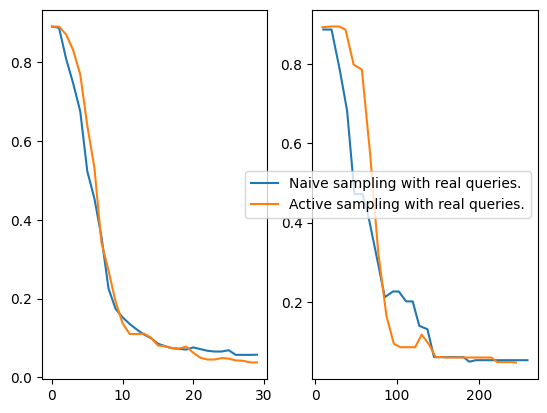

In [22]:
CLASSES = ['flaA', 'hapR', 'luxO_D47E', 'manA', 'potD1', 'rbmB', 'vpsL',
       'vpvC_W240R', 'WT']
X_train, y_train, X_test, y_test, Z ,_ = load_data(filter_class = CLASSES)

BUDGET = 30
BATCH_SIZE = 10
N = 5
figs,axs = plt.subplots(ncols = 2)

### naive sampling
l_naive = np.zeros(BUDGET)
print("Begin DH naive sampling.")

accs_passive_all = []
for i in np.arange(N):
    print("Currently on trial %d"%(i))
    queries, error, hs, P, sel, accs_passive = DH_sampling(X_train, y_train, Z, BUDGET, BATCH_SIZE, class_n=9, sampling_method="naive")
    l_naive+=error
    print(accs_passive)
    accs_passive_all.append(accs_passive)

l_naive = l_naive/N
axs[0].plot(l_naive,label = "Naive sampling")
axs[1].plot(queries, error, label = "Naive sampling with real queries.")
    
## active sampling
l_active = np.zeros(BUDGET)
print("Begin DH active sampling.")

accs_active_all = []
for i in np.arange(N):
    print("Currently on trial %d"%(i))
    queries, error, hs, P, sel, accs_dh = DH_sampling(X_train, y_train, Z, BUDGET, BATCH_SIZE, class_n=9, sampling_method="active")
    l_active+=error
    print(accs_dh)
    accs_active_all.append(accs_dh)

l_active = l_active/N
axs[0].plot(l_active,label = "Active sampling")
axs[1].plot(queries, error, label = "Active sampling with real queries.")
plt.legend()

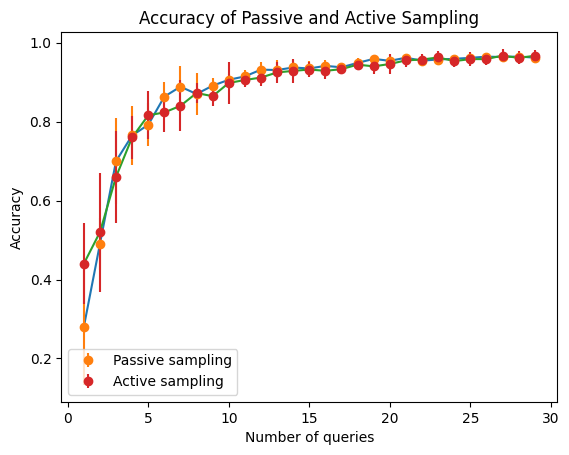

In [25]:
#plot accuracies
accs_passive_all = np.array(accs_passive_all)
accs_active_all = np.array(accs_active_all)

mean_accs_passive = np.nanmean(accs_passive_all, axis = 0)
mean_accs_active = np.nanmean(accs_active_all, axis = 0)
std_accs_passive = np.nanstd(accs_passive_all, axis = 0)
std_accs_active = np.nanstd(accs_active_all, axis = 0)

#select every 10th query
mean_accs_passive = mean_accs_passive[::10]
mean_accs_active = mean_accs_active[::10]
std_accs_passive = std_accs_passive[::10]
std_accs_active = std_accs_active[::10]

plt.figure()
plt.plot(mean_accs_passive)
plt.errorbar(np.arange(len(mean_accs_passive)), mean_accs_passive, yerr = std_accs_passive, fmt = 'o', label = "Passive sampling")
plt.plot(mean_accs_active)
plt.errorbar(np.arange(len(mean_accs_active)), mean_accs_active, yerr = std_accs_active, fmt = 'o', label = "Active sampling")
plt.legend()
plt.xlabel("Number of queries")
plt.ylabel("Accuracy")
plt.title("Accuracy of Passive and Active Sampling")
plt.show()